In [58]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
import cv2
import matplotlib.pyplot as plt

In [5]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
IMG_SIZE = train_X[0].shape

### HOG Features

A feature descriptor is a representation of an image or an image patch that simplifies the image by extracting useful information and throwing away extraneous information.
    

In [6]:
def HOG_Features(img: np.array, block_size = (8,8), block_stride = (2,2),nbins = 9) -> np.array:
    """ Histogram of Oriented Gradients
    Args:
        img (np.array): Input image
        block_size (tuple, optional):   Pixels per cell. Defaults to (8,8).
        block_stride (tuple, optional): Cells per block. Defaults to (2,2).
        nbins (int, optional):          Number of orientations.  Defaults to 9.

    Returns:
        np.array: HOG features
    """
    cell_Size = (4,4)
    HOG = cv2.HOGDescriptor(IMG_SIZE, block_size, block_stride, cell_Size, nbins)
    return HOG.compute(img)

In [7]:
def get_Features(imgs: np.array) -> np.array:
    """Obtain Hogh descriptor for all the dataset

    Args:
        imgs (np.array): Dataset

    Returns:
        np.array: HOG features of all the images
    """
    features= []
    for img in imgs:
        features.append(HOG_Features(img))
    return np.array(features)

In [8]:
features_train_x = get_Features(train_X)
features_test_x = get_Features(test_X)

In [9]:
feature_shape = features_test_x.shape[1]

### ONE-HOT Encoding

In [27]:
mnist_different_numbers = 10 #0-9
train_y_oneHot = tf.one_hot(indices = train_y, depth = 10)
test_y_oneHot = tf.one_hot(indices = test_y, depth = 10)

### Neural Net implementation

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD

In [30]:
model = Sequential([
    Dense(180, input_dim = feature_shape, activation = 'relu'),
    Dense(130, activation = 'relu'),
    Dense(40, activation = 'relu'),
    Dense(mnist_different_numbers, activation = 'Softmax')
])

model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=1e-3))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 180)               784260    
                                                                 
 dense_31 (Dense)            (None, 130)               23530     
                                                                 
 dense_32 (Dense)            (None, 40)                5240      
                                                                 
 dense_33 (Dense)            (None, 10)                410       
                                                                 
Total params: 813,440
Trainable params: 813,440
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.fit(features_train_x, train_y_oneHot, epochs=10, batch_size = 100, verbose=False)

In [75]:
prediction_train = model.predict(features_train_x, verbose=False)
prediction_test = model.predict(features_test_x, verbose=False)

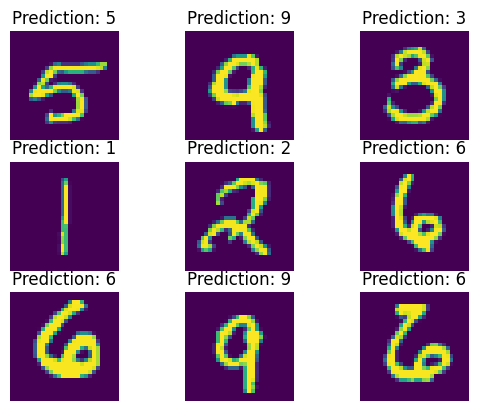

In [76]:
y_prediction_train = np.argmax(prediction_train, axis = 1)
y_prediction_test = np.argmax(prediction_test, axis = 1)

fig, axs = plt.subplots(3, 3)


for i in range(3):
    for j in range(3):
        img_n = np.random.randint(0, test_X.shape[0])
        axs[i][j].imshow(test_X[img_n])
        axs[i][j].set_title('Prediction: {}'.format(y_prediction_test[img_n]))
        axs[i][j].axis('off')
plt.show()

In [77]:
error_train = 100*np.sum(y_prediction_train != train_y)/len(train_y)
error_test = 100*np.sum(y_prediction_test != test_y)/len(test_y)

print("Train error: {}% \nTest error: {}%".format(error_train, error_test))

Train error: 2.1033333333333335% 
Test error: 2.08%


### Confusion matrix

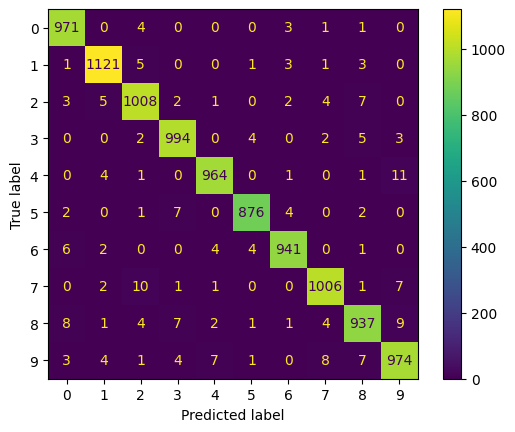

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mx = confusion_matrix(test_y, y_prediction_test)
ConfusionMatrixDisplay(conf_mx).plot()

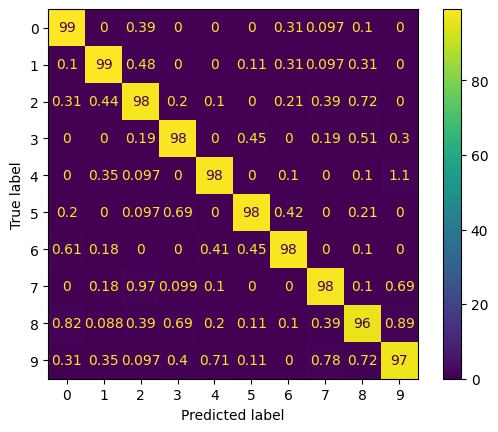

In [89]:
conf_mx_norm = 100*conf_mx/np.sum(conf_mx, 1)
ConfusionMatrixDisplay(conf_mx_norm).plot()